<a href="https://colab.research.google.com/github/IsfaquethedataAnalyst/Dataanalysis/blob/main/Health_Survey_Data_Analysis_of_BMI_Using_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
install.packages("NHANES")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [4]:
library(NHANES)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [5]:
# Load the NHANESraw data
data("NHANESraw")

# Take a glimpse at the contents
glimpse(NHANESraw)

Rows: 20,293
Columns: 78
$ ID               <int> 51624, 51625, 51626, 51627, 51628, 51629, 51630, 5163…
$ SurveyYr         <fct> 2009_10, 2009_10, 2009_10, 2009_10, 2009_10, 2009_10,…
$ Gender           <fct> male, male, male, male, female, male, female, female,…
$ Age              <int> 34, 4, 16, 10, 60, 26, 49, 1, 10, 80, 10, 80, 4, 35, …
$ AgeMonths        <int> 409, 49, 202, 131, 722, 313, 596, 12, 124, NA, 121, N…
$ Race1            <fct> White, Other, Black, Black, Black, Mexican, White, Wh…
$ Race3            <fct> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ Education        <fct> High School, NA, NA, NA, High School, 9 - 11th Grade,…
$ MaritalStatus    <fct> Married, NA, NA, NA, Widowed, Married, LivePartner, N…
$ HHIncome         <fct> 25000-34999, 20000-24999, 45000-54999, 20000-24999, 1…
$ HHIncomeMid      <int> 30000, 22500, 50000, 22500, 12500, 30000, 40000, 4000…
$ Poverty          <dbl> 1.36, 1.07, 2.27, 0.81, 0.69, 1.01, 1.91, 1.36, 2.68,…
$ HomeRooms    

2. Visualize survey weight and strata variables

We see from glimpse() that the NHANESraw data has many health measurement variables. It also contains a sampling weight variable WTMEC2YR.

Since NHANESraw data spans 4 years (2009–2012) and the sampling weights are based on 2 years of data, we first need to create a weight variable that scales the sample across the full 4 years. We will divide the 2-year weight in half so that in total, the weights sum to the total US population.

The NHANES data has oversampled some geographic regions and specific minority groups. By examining the distribution of sampling weights for each race, we can see that Whites are undersampled and have higher weights while oversampled Black, Mexican, Hispanic people have lower weights since each sampled person in these minority groups represents fewer US people.

total_WTMEC4YR
<dbl>
304267200


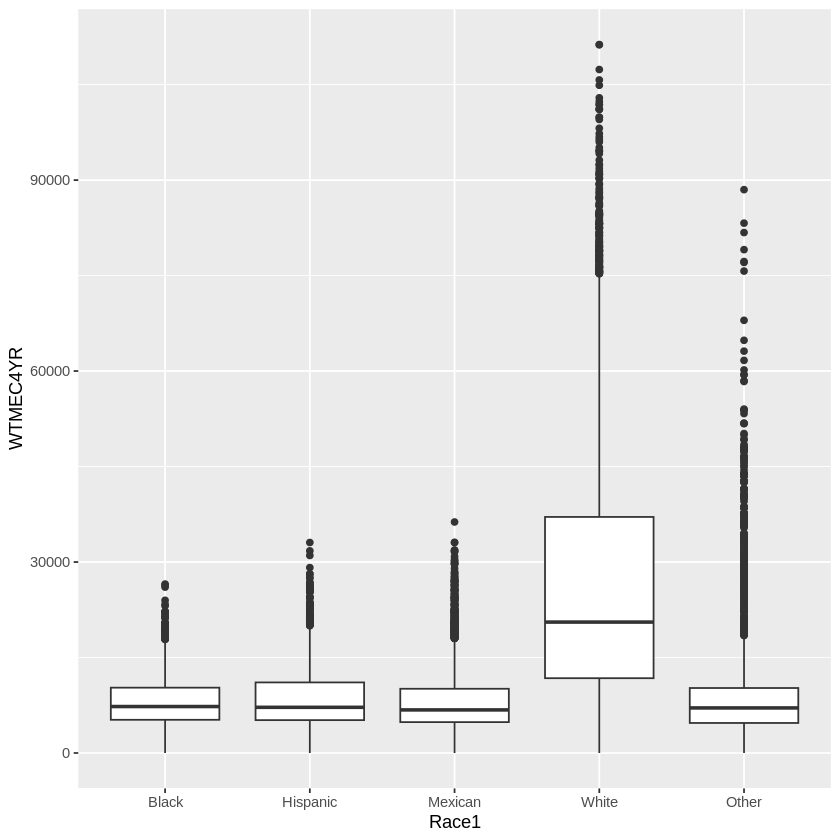

In [6]:
# Load the ggplot2 package
library(ggplot2)

# Use mutate to create a 4-year weight variable and call it WTMEC4YR
NHANESraw <- NHANESraw %>%
                mutate(WTMEC4YR = WTMEC2YR / 2)

# Calculate the sum of this weight variable
NHANESraw %>% summarize(total_WTMEC4YR = sum(WTMEC4YR))

# Plot the sample weights using boxplots, with Race1 on the x-axis
ggplot(NHANESraw, aes(x=Race1, y=WTMEC4YR))+
geom_boxplot()

3. Specify the survey design

We will now use the survey package to specify the complex survey design that we will use in later analyses. The NHANESraw data contains a strata variable SDMVSTRA, and a cluster id variable (also known as a primary sampling unit, PSU), SDMVPSU, that accounts for design effects of clustering. These clusters (PSUs) are nested within strata.

In [7]:
install.packages("survey")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘minqa’, ‘numDeriv’, ‘mitools’




In [8]:
# Load the survey package
library(survey)

# Specify the survey design
nhanes_design <- svydesign(
    data = NHANESraw,
    strata = ~SDMVSTRA,
    id = ~SDMVPSU,
    nest = TRUE,
    weights = ~WTMEC4YR)

# Print a summary of this design
summary(nhanes_design)

Loading required package: grid

Loading required package: Matrix

Loading required package: survival


Attaching package: ‘survey’


The following object is masked from ‘package:graphics’:

    dotchart




Stratified 1 - level Cluster Sampling design (with replacement)
With (62) clusters.
svydesign(data = NHANESraw, strata = ~SDMVSTRA, id = ~SDMVPSU, 
    nest = TRUE, weights = ~WTMEC4YR)
Probabilities:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
8.986e-06 5.664e-05 1.054e-04       Inf 1.721e-04       Inf 
Stratum Sizes: 
            75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
obs        803 785 823 829 696 751 696 724 713 683 592 946 598 647 251 862 998
design.PSU   2   2   2   2   2   2   2   2   2   2   2   3   2   2   2   3   3
actual.PSU   2   2   2   2   2   2   2   2   2   2   2   3   2   2   2   3   3
            92  93  94  95  96  97  98  99 100 101 102 103
obs        875 602 688 722 676 608 708 682 700 715 624 296
design.PSU   3   2   2   2   2   2   2   2   2   2   2   2
actual.PSU   3   2   2   2   2   2   2   2   2   2   2   2
Data variables:
 [1] "ID"               "SurveyYr"         "Gender"           "Age"             
 [5] "AgeMon

4. Subset the data

Analysis of survey data requires careful consideration of the sampling design and weights at every step. Something as simple as filtering the data becomes complicated when weights are involved.

When we wish to examine a subset of the data (i.e. the subpopulation of adult Hispanics with diabetes, or pregnant women), we must explicitly specify this in the design. We cannot simply remove that subset of the data through filtering the raw data because the survey weights will no longer be correct and will not add up to the full US population.

BMI categories are different for children and young adults younger than 20 so we will subset the data to only analyze adults of at least 20 years of age.

In [9]:
# Select adults of Age >= 20 with subset
nhanes_adult <- nhanes_design%>%
                subset(Age >=20)

# Print a summary of this subset
summary(nhanes_adult)

# Compare the number of observations in the full data to the adult data
nrow(nhanes_adult)
nrow(nhanes_design)

Stratified 1 - level Cluster Sampling design (with replacement)
With (62) clusters.
subset(., Age >= 20)
Probabilities:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
8.986e-06 4.303e-05 8.107e-05       Inf 1.240e-04       Inf 
Stratum Sizes: 
            75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
obs        471 490 526 500 410 464 447 400 411 395 357 512 327 355 153 509 560
design.PSU   2   2   2   2   2   2   2   2   2   2   2   3   2   2   2   3   3
actual.PSU   2   2   2   2   2   2   2   2   2   2   2   3   2   2   2   3   3
            92  93  94  95  96  97  98  99 100 101 102 103
obs        483 376 368 454 362 315 414 409 377 460 308 165
design.PSU   3   2   2   2   2   2   2   2   2   2   2   2
actual.PSU   3   2   2   2   2   2   2   2   2   2   2   2
Data variables:
 [1] "ID"               "SurveyYr"         "Gender"           "Age"             
 [5] "AgeMonths"        "Race1"            "Race3"            "Education"       
 [9] "Marita

[1] 11778

[1] 20293

5. Visualizing BMI

We let svydesign() do its magic, but how does this help us learn about the full US population? With survey methods, we can use the sampling weights to estimate the true distributions of measurements within the entire population. This works for many statistics such as means, proportions, and standard deviations.

We'll use survey methods to estimate average BMI in the US adult population and also to draw a weighted histogram of the distribution.

avg.BMI
<dbl>
28.98217


      mean     SE
BMI 28.734 0.1235

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 547 rows containing non-finite values (`stat_bin()`).”


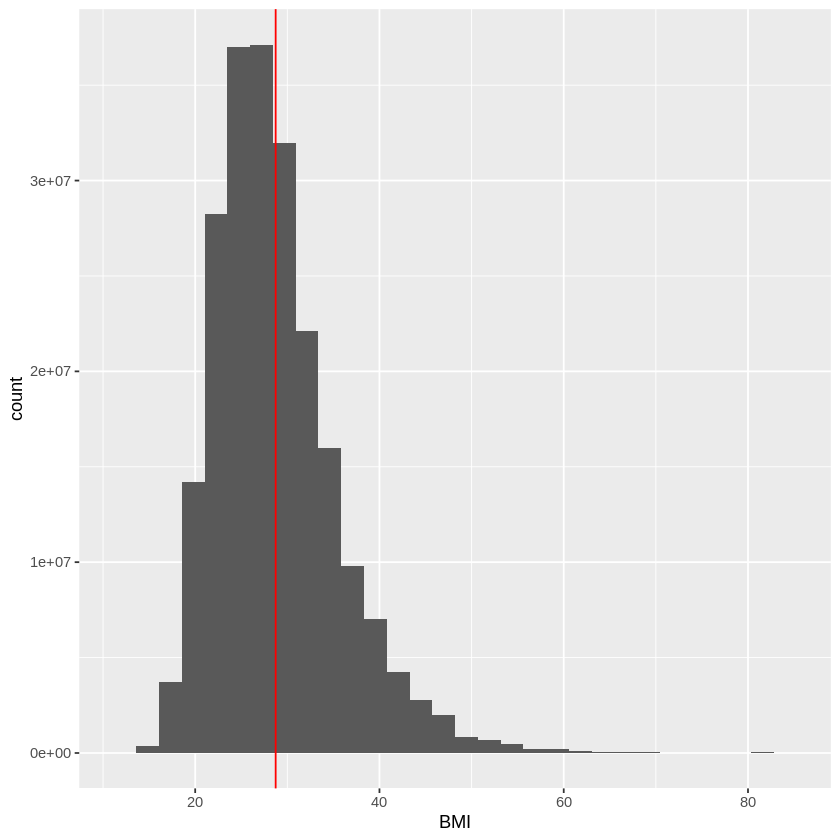

In [10]:
# Calculate the mean BMI in NHANESraw
bmi_mean_raw <- NHANESraw %>%
    filter(Age >= 20) %>%
    summarize(avg.BMI = mean(BMI, na.rm=TRUE))
bmi_mean_raw

# Calculate the survey-weighted mean BMI of US adults
bmi_mean <- svymean(~BMI, design = nhanes_adult, na.rm = TRUE)
bmi_mean

# Draw a weighted histogram of BMI in the US population
NHANESraw %>%
  filter(Age >= 20) %>%
    ggplot(mapping=aes(x=BMI, weight=WTMEC4YR)) +
    geom_histogram()+
    geom_vline(xintercept = coef(bmi_mean), color="red")

6. Is BMI lower in physically active people?

The distribution of BMI looks to be about what we might expect with most people under 40 kg/m2 and a slight positive skewness because a few people have much higher BMI. Now to the question of interest: does the distribution of BMI differ between people who are physically active versus those who are not physically active? We can visually compare BMI with a boxplot as well as formally test for a difference in mean BMI.

In [11]:
install.packages("broom")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Warning message:
“Removed 547 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Computation failed in `stat_boxplot()`
Caused by error in `loadNamespace()`:
! there is no package called ‘quantreg’”


estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-1.846458,-9.716503,4.56031e-11,32,-2.233542,-1.459373,Design-based t-test,two.sided


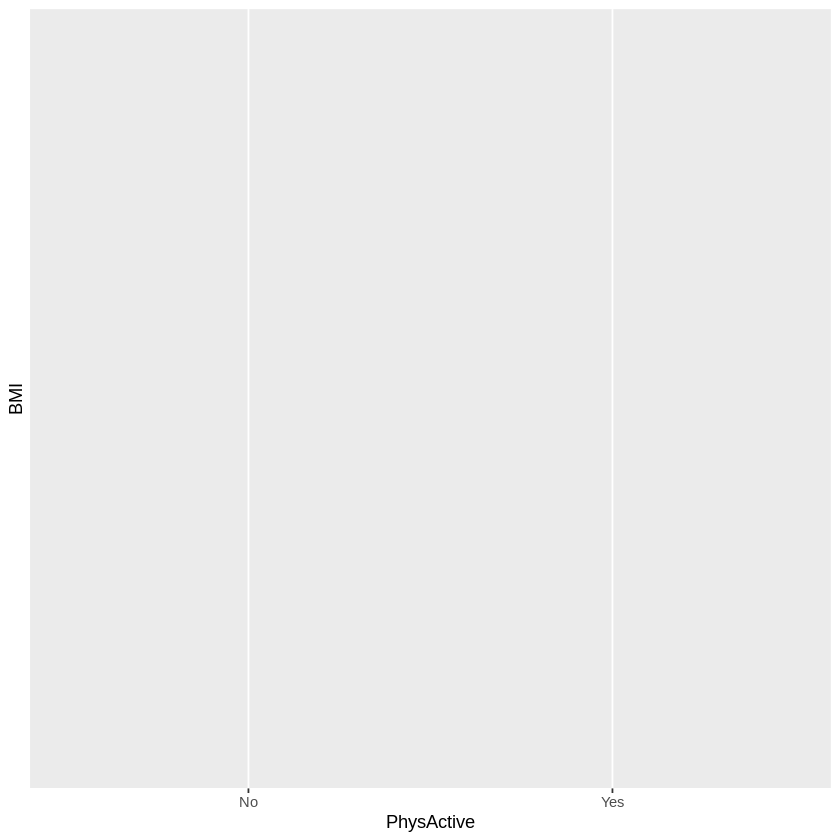

In [12]:
# Load the broom library
library(broom)

# Make a boxplot of BMI stratified by physically active status
NHANESraw %>%
  filter(Age>=20) %>%
    ggplot(mapping=aes(x=PhysActive, y= BMI, weight=WTMEC4YR))+
    geom_boxplot()

# Conduct a t-test comparing mean BMI between physically active status
survey_ttest <- svyttest(BMI~PhysActive, design = nhanes_adult)

# Use broom to show the tidy results
tidy(survey_ttest)

,SmokeNow,PhysActiveNo,PhysActiveYes,se.PhysActiveNo,se.PhysActiveYes
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,No,0.4566990,0.5433010,0.01738054,0.01738054
2,Yes,0.5885421,0.4114579,0.01163246,0.01163246


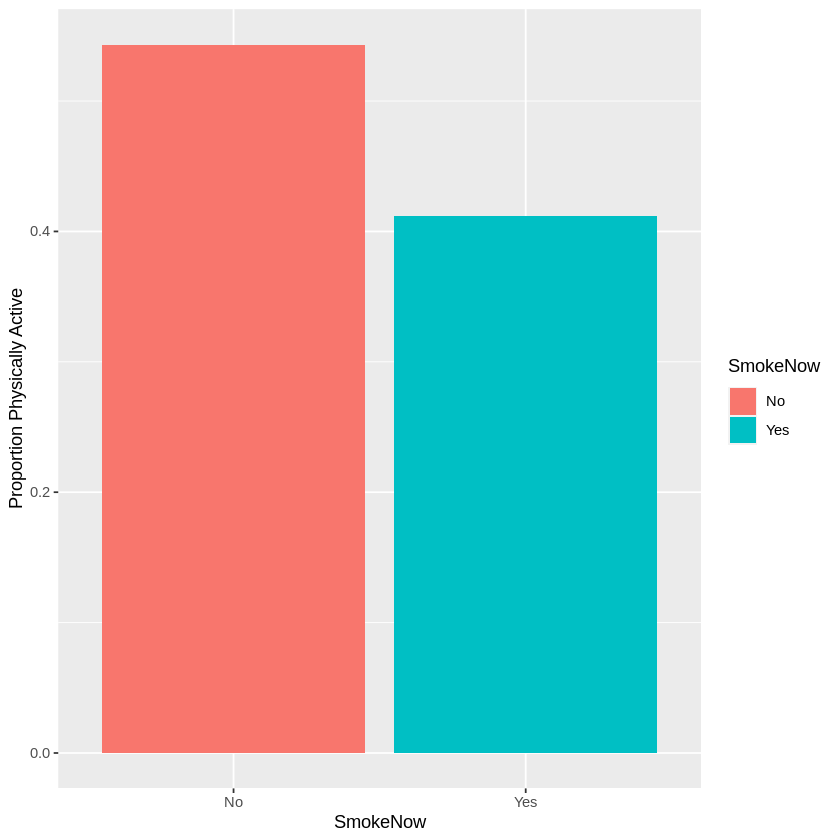

In [13]:

# Estimate the proportion who are physically active by current smoking status
phys_by_smoke <- svyby(~PhysActive, by = ~SmokeNow,
                       FUN = svymean,
                       design = nhanes_adult,
                       keep.names = FALSE)

# Print the table
phys_by_smoke

# Plot the proportions
ggplot(data = phys_by_smoke, aes(SmokeNow, PhysActiveYes, fill = SmokeNow)) +
 geom_col()+
    ylab("Proportion Physically Active")

8. Could there be confounding by smoking? (part 2)

Now let's examine the relationship between smoking with BMI.

In [15]:
install.packages("ggplot2")
install.packages("quantreg")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘SparseM’, ‘MatrixModels’




,SmokeNow,BMI,se
,<fct>,<dbl>,<dbl>
No,No,29.25734,0.1915138
Yes,Yes,27.74873,0.1652377


Warning message:
“Removed 244 rows containing non-finite values (`stat_boxplot()`).”


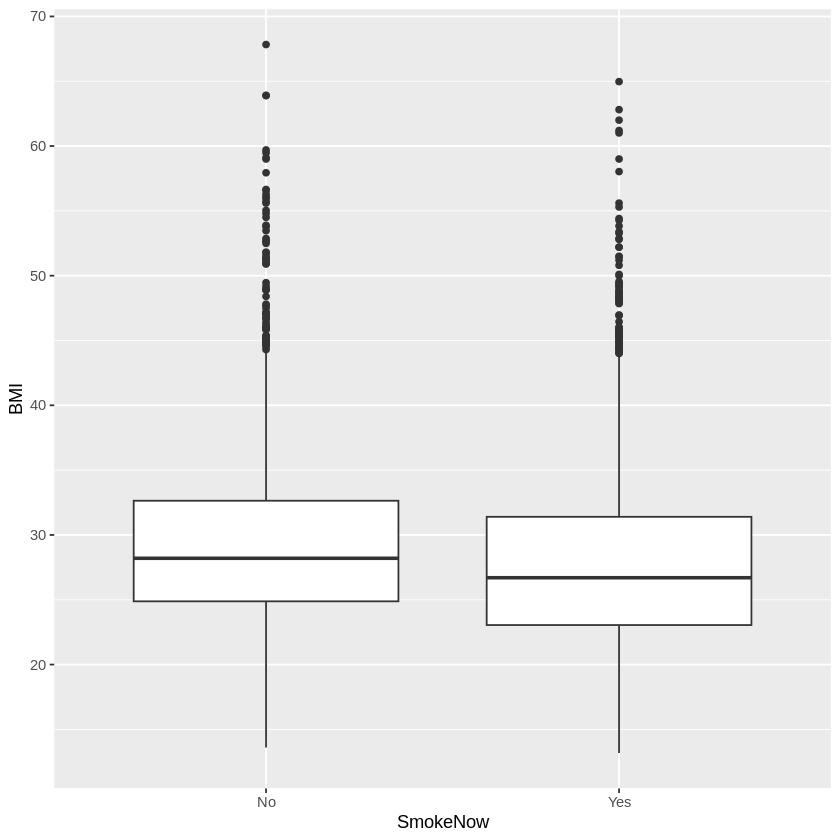

In [17]:
# Estimate mean BMI by current smoking status
BMI_by_smoke <- svyby(~BMI, by = ~SmokeNow,
                       FUN = svymean,
                       design = nhanes_adult,
                       na.rm = TRUE)
BMI_by_smoke

# Plot the distribution of BMI by current smoking status
NHANESraw %>%
  filter(Age>=20, !is.na(SmokeNow)) %>%
    ggplot(mapping=aes(x=SmokeNow, y= BMI, weight=WTMEC4YR))+
    geom_boxplot()

9. Add smoking in the mix

We saw that people who smoke are less likely to be physically active and have a higher BMI on average. We also saw that people who are physically active have a lower BMI on average. How do these seemingly conflicting associations work together? To get a better sense of what's going on, we can compare BMI by physical activity stratified by smoking status.

In [16]:
library(quantreg)

Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve



Attaching package: ‘quantreg’


The following object is masked from ‘package:survival’:

    untangle.specials




Warning message:
“Removed 547 rows containing non-finite values (`stat_boxplot()`).”


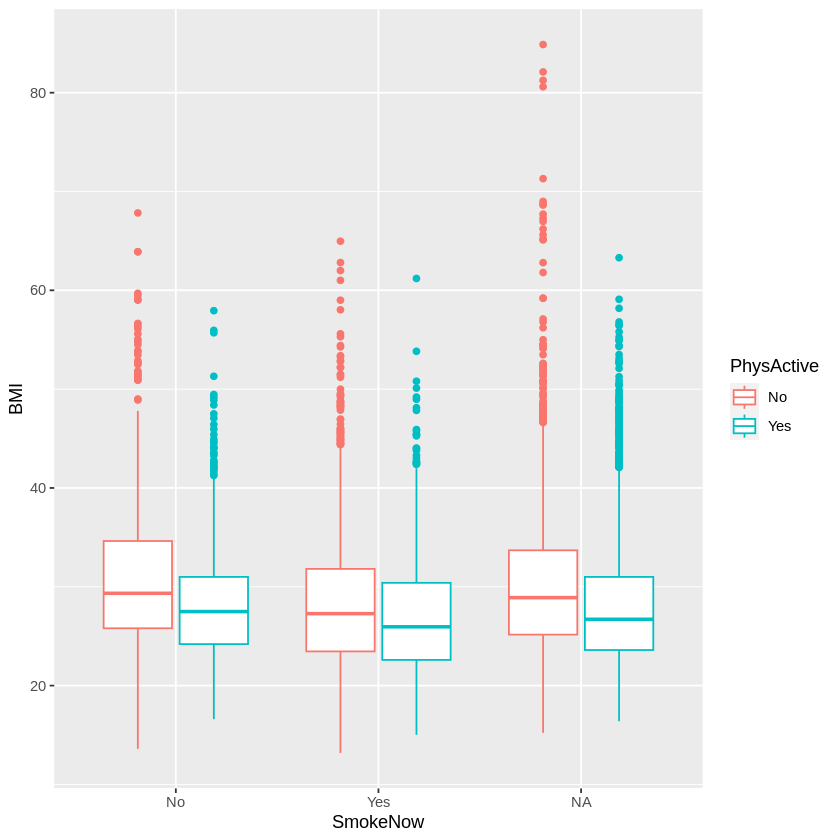

In [18]:
# Plot the distribution of BMI by smoking and physical activity status
NHANESraw %>%
  filter(Age>=20) %>%
    ggplot(mapping=aes(x=SmokeNow, y= BMI, weight=WTMEC4YR, color=PhysActive))+
    geom_boxplot()

In [19]:
# Fit a multiple regression model
mod1 <- svyglm(BMI ~ SmokeNow * PhysActive, design = nhanes_adult)

# Tidy the model results
tidy_mod1 <- tidy(mod1)
tidy_mod1

# Calculate expected mean difference in BMI for activity within non-smokers
diff_non_smoke <- tidy_mod1 %>%
    filter(term == "PhysActiveYes") %>%
    select(estimate)
diff_non_smoke

# Calculate expected mean difference in BMI for activity within smokers
diff_smoke <- tidy_mod1 %>%
   filter(term %in% c('PhysActiveYes','SmokeNowYes:PhysActiveYes')) %>%
    summarize(estimate = sum(estimate))
diff_smoke

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),30.540997,0.2098466,145.539656,2.619435e-44
SmokeNowYes,-2.238390,0.2665632,-8.397223,2.262528e-09
PhysActiveYes,-2.350701,0.2358895,-9.965262,4.961177e-11
SmokeNowYes:PhysActiveYes,1.004490,0.3435443,2.923903,6.520735e-03


estimate
<dbl>
-2.350701


estimate
<dbl>
-1.346211


In [20]:
# Adjust mod1 for other possible confounders
mod2 <- svyglm(BMI ~ PhysActive*SmokeNow + Race1 + Alcohol12PlusYr + Gender,
               design = nhanes_adult)

# Tidy the output
tidy(mod2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),33.2378322,0.3162940,105.0852370,1.745688e-33
PhysActiveYes,-2.1140302,0.2729173,-7.7460482,5.559290e-08
SmokeNowYes,-2.2266832,0.3034114,-7.3388252,1.402940e-07
Race1Hispanic,-1.4670407,0.4200193,-3.4927937,1.875493e-03
Race1Mexican,-0.1909654,0.4637845,-0.4117546,6.841735e-01
Race1White,-2.0761158,0.3200810,-6.4862209,1.043842e-06
Race1Other,-3.1050466,0.6202084,-5.0064570,4.089394e-05
Alcohol12PlusYrYes,-0.8549211,0.3575930,-2.3907660,2.501002e-02
Gendermale,-0.2557363,0.2302174,-1.1108470,2.776397e-01
